# 动态加载 和 抓包



## 爬职简书网用户动态信息

首次打开该网页URL时，单击"动态"链接后，发现网页URL并没有发生变化，所以判断该网页采用了异步加载技术。

抓包，加载动态时的文件

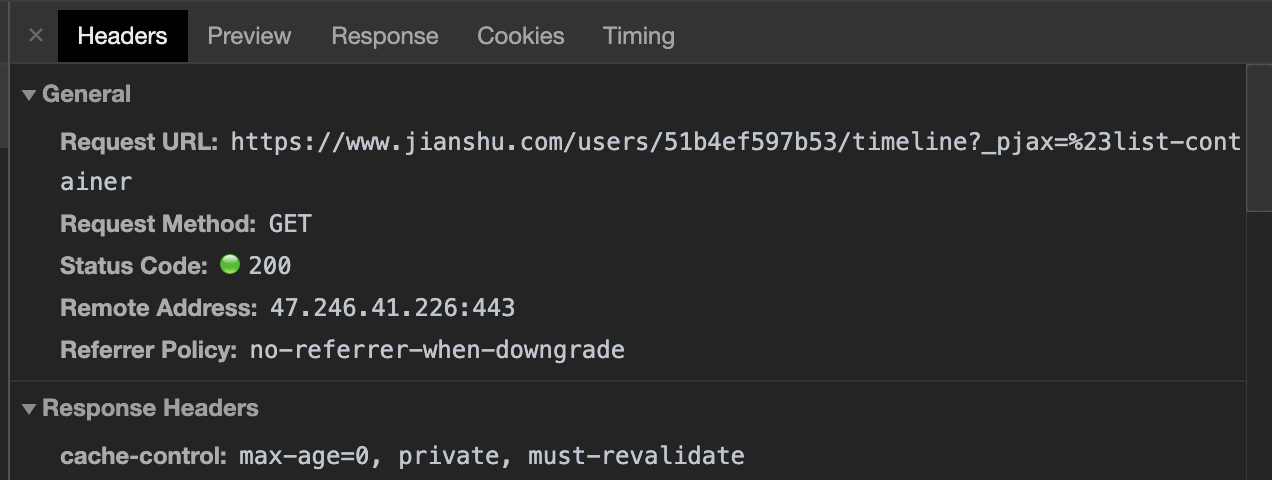


从 Response 那看
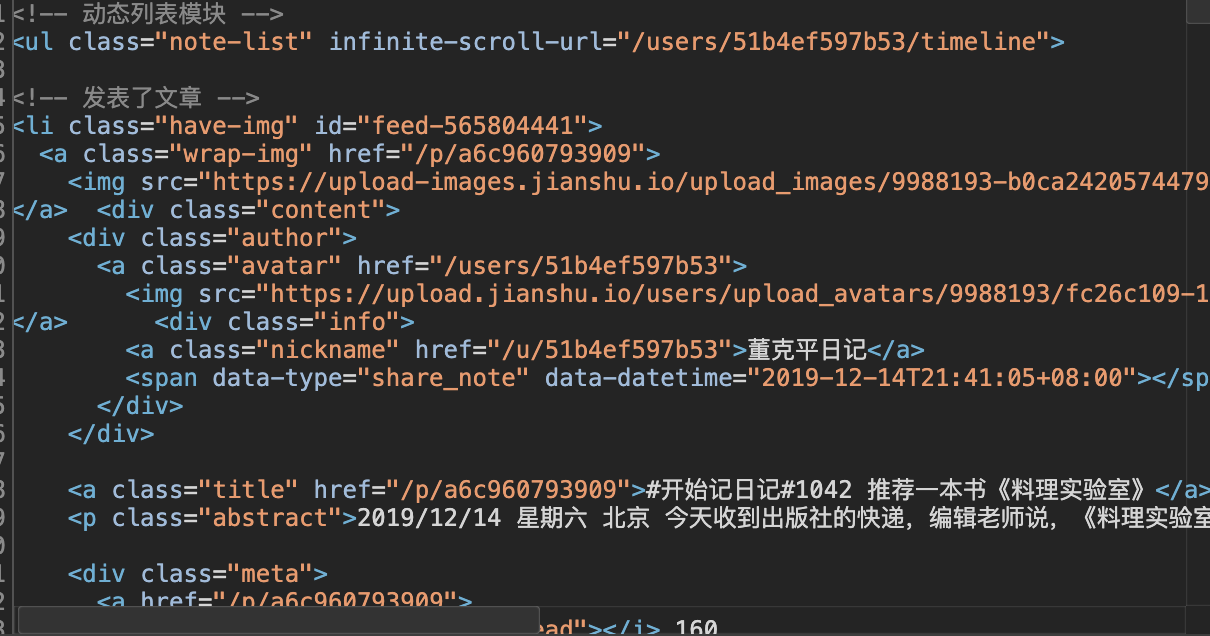

返回的是 XML 文件，记载每一个动态内容


往下滑，发现更多页也是动态加载的

抓包看，

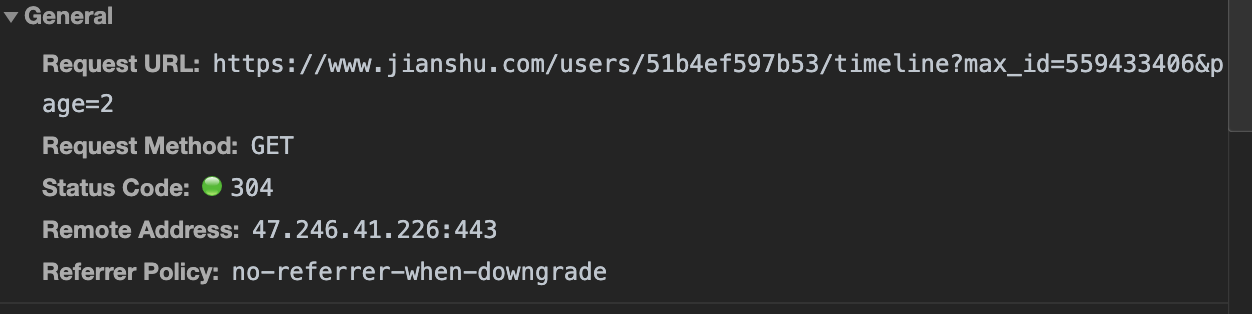


https://www.jianshu.com/users/51b4ef597b53/timeline?max_id=559433406&page=2

https://www.jianshu.com/users/51b4ef597b53/timeline?max_id=552091110&page=3

https://www.jianshu.com/users/51b4ef597b53/timeline?max_id=544440260&page=4

但是发现仅仅改 page= 后面的数字不能转到下一页，说明这个 max_id 参数是有用的

观察 response 发现前一页最后一个文章 id 正好比下一个请求的动态包网址里的 max_id 多一。

这样就可以构建 url


In [3]:
import requests
from lxml import etree
import re
import time
import pymongo


headers = {
    'user-agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.108 Safari/537.36"
}


In [4]:
client = pymongo.MongoClient('localhost', 27017)
db = client['mydb']
timeline = db['jianshu_timeline']

In [70]:
def get_timeline_info(url, page):
    user_id = url.split("/")[4]
    if url.find("page="):
        page = page + 1
    
    
    res = requests.get(url, headers = headers)
    selector = etree.HTML(res.text)
    _id = [ x[5:] for x in selector.xpath('//ul[@class="note-list"]/li/@id')]

    publish_time = selector.xpath('//*[@id="list-container"]/ul/li/div/div[1]/div/span/@data-datetime')

    action_type = selector.xpath('//*[@id="list-container"]/ul/li/div/div[1]/div/span/@data-type')
    views = [int(x.strip()) for x in re.findall('<i class="iconfont ic-list-read"></i>(.*?)</a>', res.text, re.S)]

    comments  = [int(x.strip()) for x in re.findall('<i class="iconfont ic-list-comments"></i>(.*?)</a>', res.text, re.S)]
    likes = [int(x.strip()) for x in re.findall('<i class="iconfont ic-list-like"></i>(.*?)</span>',res.text, re.S)]
    
    for i in zip(_id, publish_time, action_type, views, comments, likes):
        
        info = {"_id": i[0],
                "publish_time": i[1],
                "action_typen": i[2],
                "views": i[3],
                "comments": i[4],
                "likes": i[5],

        }

        timeline.insert_one(info)
    
    if len(_id)>0:
        max_id = str(int(_id[-1])+1)
        next_url = "https://www.jianshu.com/users/%s/timeline?max_id=%s&page=%s" % (user_id, max_id, page)
    get_timeline_info(next_url, page)

In [71]:
get_timeline_info("https://www.jianshu.com/users/51b4ef597b53/timeline",1)

DuplicateKeyError: E11000 duplicate key error collection: mydb.jianshu_timeline index: _id_ dup key: { _id: "559471086" }

In [55]:


# try:

# except requests.exceptions.ConnectionError:
#     pass

# try:
# except IndexError: